In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

sequence_length = 365
training_days = 1200

# load the training data
training = pd.read_parquet('data/training.parquet')
lats = training['lat'].unique()
features = []
targets = []
for lat in lats[0:4]:
    # slice the data by latitude
    this = training[training['lat'] == lat]
    for i in range(0,training_days):
        feature_vec = this['ndvi_smoothed'][i:i+sequence_length].values
        target = this['ndvi_smoothed'][i+sequence_length]
        # convert feature_vec to a tensor
        feature_vec = torch.tensor(feature_vec, dtype=torch.float32)
        # convert target to a tensor
        target = torch.tensor(target, dtype=torch.float32)
        features.append(feature_vec)
        targets.append(target)



features = torch.stack(features)
features = features.unsqueeze(-1)
targets = torch.stack(targets)
targets = targets.unsqueeze(-1)

features.shape, targets.shape

(torch.Size([4800, 365, 1]), torch.Size([4800, 1]))

In [3]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MyModel, self).__init__()
        self.f = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.f(x)
        out = self.fc(out[:, -1, :])
        return out

num_epochs = 700
input_size = 1
hidden_size = 8  # 16
num_layers = 1
model = MyModel(input_size, hidden_size, num_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
# print("Training...")
# for epoch in range(num_epochs):
#     outputs = model(features)
#     loss = criterion(outputs, targets)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     if (epoch + 1) % 100 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [4]:
# save the model weights to disk
# torch.save(model.state_dict(), 'model_weights.pth')
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

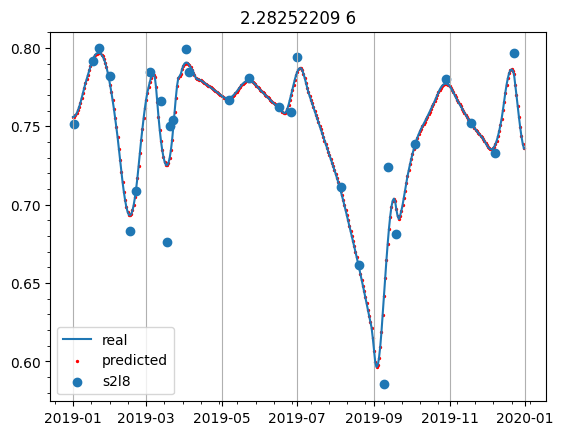

In [13]:
import matplotlib.pyplot as plt

def predict(recent_history):
    # recent_history is a list of floats
    # convert recent_history to a tensor
    recent_history = torch.tensor(recent_history, dtype=torch.float32)
    # add a batch dimension
    recent_history = recent_history.unsqueeze(0)
    # add a feature dimension
    recent_history = recent_history.unsqueeze(-1)
    # predict
    prediction = model(recent_history)
    # convert prediction to a float
    prediction = prediction.item()
    return prediction

# load s2l8.parquet
s2l8 = pd.read_parquet('data/s2l8.parquet')
where = 6
pure = s2l8[s2l8['lat'] == lats[where]]
this = training[training['lat'] == lats[where]]
start_date = '2019-01-01'
end_date = '2019-12-31'
pure = pure[pure['time'] >= start_date]
pure = pure[pure['time'] <= end_date]
# limit this to just dates in year 2020
this = this[this['time'] >= start_date]
this = this[this['time'] <= end_date]


# set nn to be the first sequence_length values of ndvi_smoothed
nn = this[0:sequence_length]
nn = nn.drop(['lat','ndvi'], axis=1)
current_feature = this['ndvi_smoothed'][0:sequence_length].values
for i in range(sequence_length,this.shape[0]):
    # get the ith row of this
    row = this.iloc[i]
    date = row['time']
    # check if this date exists in s2l8
    if date in pure['time'].values:
        # we have a real measurement
        x = {'time':date, 'ndvi_smoothed':row['ndvi_smoothed']}
        # pd.concatenate nn and x
        nn = pd.concat([nn, pd.DataFrame(x, index=[0])], ignore_index=True)
        current_feature = this['ndvi_smoothed'][i-sequence_length+1:i+1].values
    else:
        print("predicting")
        # we need to predict
        prediction = predict(current_feature)
        # add prediction to nn
        x = {'time':date, 'ndvi_smoothed':prediction}
        nn = pd.concat([nn, pd.DataFrame(x, index=[0])], ignore_index=True)
        # update current_feature
        current_feature = np.append(current_feature[1:], prediction)

# plot this['ndvi_smoothed'] and nn['ndvi_smoothed'] with legends vs time
plt.plot(this['time'], this['ndvi_smoothed'], label='real')
# title is lat[where] concatentated with which
plt.title(str(lats[where]) + ' ' + str(where))

plt.scatter(nn['time'], nn['ndvi_smoothed'], label='predicted',s=2,color='red')
# plots s2l8['ndvi'] vs time
plt.scatter(pure['time'], pure['ndvi'], label='s2l8')
# add vertical grid lines
plt.grid(axis='x')
# add minor vertical grid lines
plt.minorticks_on()


plt.legend()
plt.show()









3767


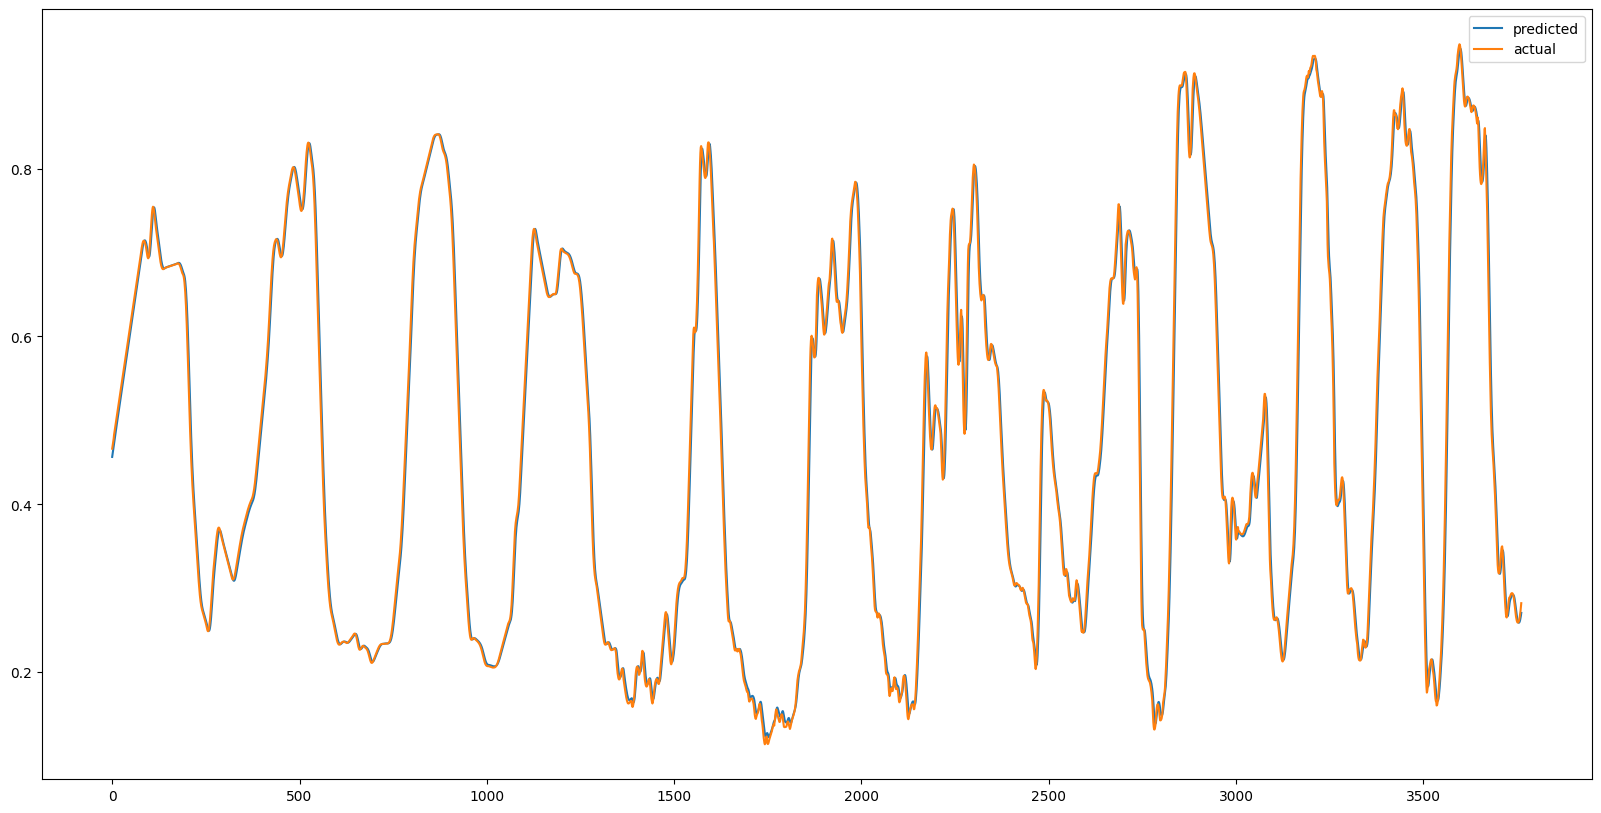

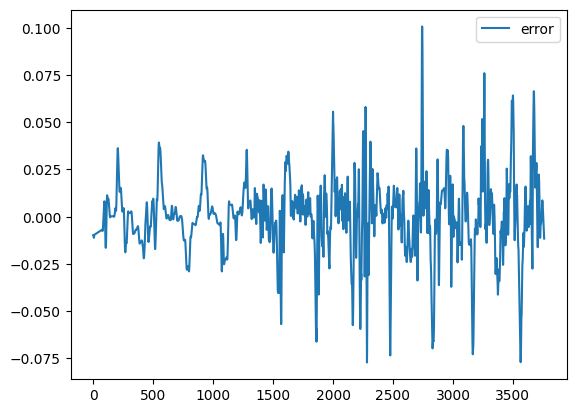

In [239]:
# slice the training data by latitude
this = training[training['lat'] == lats[0]]
print(len(this))
# results is a datafrom with columns 'predicted', 'actual', 'error'
results = pd.DataFrame(columns=['predicted', 'actual', 'error'])
for i in range(0,this.shape[0]-sequence_length):
    feature_vec = this['ndvi_smoothed'][i:i+sequence_length].values
    target = this['ndvi_smoothed'][i+sequence_length]
    # convert feature_vec to a tensor
    feature_vec = torch.tensor(feature_vec, dtype=torch.float32)
    feature_vec = feature_vec.view(1,-1,1)
    predicted = model(feature_vec)
    row = {'predicted': predicted.item(), 'actual': target, 'error': predicted.item() - target}
    # concatenate the row to the results dataframe
    results = pd.concat([results, pd.DataFrame(row, index=[0])], ignore_index=True)

#plot the results
plt.figure(figsize=(20,10))
plt.plot(results['predicted'], label='predicted')
plt.plot(results['actual'], label='actual')
plt.legend()
plt.show()
plt.plot(results['error'], label='error')
plt.legend()
plt.show()

    
    
    


3648

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

lats = np.fromfile('data/lats.bin', dtype=np.float64)

num_training_lats = 5
oos = 188
sequence_length = 140
num_epochs = 1200

input_sequences = []
target_values = []
for i in range(num_training_lats):
    lat = lats[i]
    filename = 'data/' + str(lat) + '.bin'
    all_data = np.loadtxt(f'data/{lat}.csv', delimiter=',', dtype=np.float32,skiprows=1)
    data = all_data[:-oos]
    # Convert the data to PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32).view(-1, 1)
    # Define the sequence length and prepare input-target pairs
    for i in range(len(data_tensor) - sequence_length):
        input_sequences.append(data_tensor[i:i + sequence_length])
        target_values.append(data_tensor[i + sequence_length])

input_sequences = torch.stack(input_sequences)
target_values = torch.stack(target_values)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 32  # You can adjust this based on your requirements
num_layers = 1
model = LSTMModel(input_size, hidden_size, num_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
print("Training...")
for epoch in range(num_epochs):
    outputs = model(input_sequences)
    loss = criterion(outputs, target_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')





Training...
Epoch [100/1200], Loss: 0.0079
Epoch [200/1200], Loss: 0.0033
Epoch [300/1200], Loss: 0.0027
Epoch [400/1200], Loss: 0.0019
Epoch [500/1200], Loss: 0.0011
Epoch [600/1200], Loss: 0.0006
Epoch [700/1200], Loss: 0.0004
Epoch [800/1200], Loss: 0.0003
Epoch [900/1200], Loss: 0.0002
Epoch [1000/1200], Loss: 0.0001
Epoch [1100/1200], Loss: 0.0001
Epoch [1200/1200], Loss: 0.0001


In [21]:
# save the model weights to disk
torch.save(model.state_dict(), 'model_weights.pth')
# model.load_state_dict(torch.load('model_weights.pth'))

In [89]:
# sanity check
model.eval()
last_sequence = input_sequences[0]
print(input_sequences[0])
model(last_sequence.view(1, sequence_length, 1))

# foo = range(0,sequence_length)
# # change foo to tensor
# foo = torch.tensor(foo, dtype=torch.float32).view(-1, 1)
# foo.view(1, sequence_length, 1)
# # print dimensions of foo
# print(foo.shape)
# print(foo.view(1, sequence_length, 1).shape)
# bar = range(0,10)
# # convert bar to tensor
# bar = torch.tensor(bar, dtype=torch.float32).view(1,-1, 1)
# print(bar.shape)
# model(bar)




tensor([[0.2183],
        [0.2096],
        [0.2019],
        [0.1953],
        [0.1899],
        [0.1854],
        [0.1821],
        [0.1798],
        [0.1786],
        [0.1785],
        [0.1803],
        [0.1818],
        [0.1840],
        [0.1875],
        [0.1927],
        [0.1998],
        [0.2091],
        [0.2207],
        [0.2348],
        [0.2510],
        [0.2689],
        [0.2891],
        [0.3114],
        [0.3355],
        [0.3612],
        [0.3880],
        [0.4156],
        [0.4434],
        [0.4709],
        [0.4974],
        [0.5223],
        [0.5480],
        [0.5738],
        [0.5993],
        [0.6240],
        [0.6475],
        [0.6697],
        [0.6902],
        [0.7088],
        [0.7252],
        [0.7394],
        [0.7513],
        [0.7611],
        [0.7688],
        [0.7748],
        [0.7792],
        [0.7825],
        [0.7852],
        [0.7878],
        [0.7908],
        [0.7950],
        [0.7992],
        [0.8034],
        [0.8076],
        [0.8117],
        [0

tensor([[0.5289]], grad_fn=<AddmmBackward0>)

In [90]:
import pandas as pd
m = pd.read_parquet('data/s2l8.parquet')

lat = lats[num_training_lats]
lat = lats[0]

# slice off lat = lat from m
m = m[m.lat == lat]

min_date = m["time"].min()
max_date = m["time"].max()
date_range = pd.date_range(min_date, max_date, freq='D')  # Create a date range with daily frequency
m1 = pd.DataFrame({"time": date_range})
m1 = pd.merge(m1, m, on="time", how="left")
m1["ndvi"] = m1["ndvi"].interpolate()
print(m1)


m2 = m1.copy()

model.eval()
last_sequence = m1["ndvi"].values[0:sequence_length]
print("last sqeuence")
print(last_sequence)
last_sequence = torch.tensor(last_sequence, dtype=torch.float32).view(1, -1,1)
model(last_sequence)



           time        lat      ndvi
0    2013-04-22 -34.065146  0.451291
1    2013-04-23        NaN  0.454291
2    2013-04-24        NaN  0.457292
3    2013-04-25        NaN  0.460293
4    2013-04-26        NaN  0.463293
...         ...        ...       ...
3762 2023-07-11        NaN  0.269035
3763 2023-07-12        NaN  0.271390
3764 2023-07-13        NaN  0.273745
3765 2023-07-14        NaN  0.276100
3766 2023-07-15 -34.065146  0.278454

[3767 rows x 3 columns]
last sqeuence
[0.45129078 0.45429142 0.45729207 0.46029271 0.46329336 0.466294
 0.46929465 0.47229529 0.47529594 0.47829658 0.48129722 0.48429787
 0.48729851 0.49029916 0.4932998  0.49630045 0.49930109 0.50230174
 0.50530238 0.50830303 0.51130367 0.51430432 0.51730496 0.52030561
 0.52330625 0.5263069  0.52930754 0.53230819 0.53530883 0.53830948
 0.54131012 0.54431076 0.54731141 0.55031205 0.5533127  0.55631334
 0.55931399 0.56231463 0.56531528 0.56831592 0.57131657 0.57431721
 0.57731786 0.5803185  0.58331915 0.58631979 0.589

tensor([[0.5596]], grad_fn=<AddmmBackward0>)

In [58]:
# print(last_sequence)
# print(last_sequence.view(1, sequence_length, 1))
model(last_sequence.view(1, sequence_length, 1))


tensor([[0.5596]], grad_fn=<AddmmBackward0>)

In [ ]:

for i in range(len(m1) - sequence_length):
    this_date = m1.iloc[i + sequence_length]["time"]
    # does this_date exist in m?
    if this_date in m["time"].values:
        # yes, so use the actual value
        output.append(m1.iloc[i + sequence_length]["ndvi"])
        last_sequence = data_tensor[i:sequence_length+i] 
        continue
    else:
        # no, so use the predicted value
        prediction = model(last_sequence.view(1, sequence_length, 1))
        output.append(prediction.item())
        # remove the first element of last_sequence and add the prediction to the end
        last_sequence = torch.cat([last_sequence[:, 1:, :], prediction.view(1, 1, 1)], dim=1)


# replace the ndvi column with the predicted values
m2["ndvi"] = output

# now m1 should be interpolated and m2 should be extrapolated
#plot m1 and m2
import matplotlib.pyplot as plt
plt.plot(m1["time"], m1["ndvi"], label="interpolated")
plt.plot(m2["time"], m2["ndvi"], label="extrapolated")
plt.legend()
plt.show()


    
    


In [36]:
prediction

tensor([[0.4180]], grad_fn=<AddmmBackward0>)

In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

oos = 188
print(oos)
# Assuming you have a list of 2000 numbers
# load data into a list from a csv file
all_data = np.loadtxt('data/-15.298912.csv', delimiter=',', dtype=np.float32,skiprows=1)
# subset all_data to all but the last 1000 numbers
data = all_data[:-oos]
test = all_data[-oos:]

# Convert the data to PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.float32).view(-1, 1)

# Define the sequence length and prepare input-target pairs
sequence_length = 140  # You can adjust this value based on the desired sequence length
input_sequences = []
target_values = []

for i in range(len(data_tensor) - sequence_length):
    input_sequences.append(data_tensor[i:i + sequence_length])
    target_values.append(data_tensor[i + sequence_length])

input_sequences = torch.stack(input_sequences)
target_values = torch.stack(target_values)

# Normalize the data (optional but can help with training)
# data_mean = input_sequences.mean()
# data_std = input_sequences.std()
# input_sequences = (input_sequences - data_mean) / data_std

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 32  # You can adjust this based on your requirements
num_layers = 1
model = LSTMModel(input_size, hidden_size, num_layers)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 1000  # You can adjust this based on the desired number of epochs
for epoch in range(num_epochs):
    outputs = model(input_sequences)
    loss = criterion(outputs, target_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')




188
Epoch [100/1000], Loss: 0.0001
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000


In [118]:
input_sequences.shape, target_values.shape,len(all_data)

(torch.Size([19, 140, 1]), torch.Size([19, 1]), 347)

In [18]:
# # Make predictions for the next number
# model.eval()
# with torch.no_grad():
#     last_sequence = input_sequences[-1].view(1, sequence_length, 1)
#     # print(last_sequence)
#     prediction = model(last_sequence)
#     print(prediction)
#     # predicted_next_number = (prediction * data_std) + data_mean
#     predicted_next_number = (prediction)

# print(f"Predicted next number: {predicted_next_number.item()}")

In [19]:
model.eval()
last_sequence = input_sequences[-1].view(1, sequence_length, 1)
output = []
# print(last_sequence)
for i in range(oos):
    with torch.no_grad():
        prediction = model(last_sequence)
        print(f"{prediction.item()},{test[i]}")
        output.append(prediction.item())
        # remove the first element of last_sequence and add the prediction to the end
        last_sequence = torch.cat([last_sequence[:, 1:, :], prediction.view(1, 1, 1)], dim=1)





0.5267245769500732,0.540952205657959
0.5265795588493347,0.5459277033805847
0.5265169143676758,0.5514300465583801
0.5264595746994019,0.560250997543335
0.5264091491699219,0.5674099326133728
0.5263667702674866,0.5732500553131104
0.5263322591781616,0.5780969262123108
0.5263048410415649,0.5783967971801758
0.5262832641601562,0.5778055787086487
0.5262665152549744,0.5765014290809631
0.5262536406517029,0.5747028589248657
0.5262437462806702,0.5726689100265503
0.5262361764907837,0.5706986784934998
0.5262304544448853,0.5680713653564453
0.5262261033058167,0.5652843713760376
0.5262227654457092,0.562819242477417
0.5262203216552734,0.5611411333084106
0.5262184143066406,0.5606990456581116
0.526216983795166,0.5647078156471252
0.5262159109115601,0.571541965007782
0.526215136051178,0.5778785347938538
0.5262144804000854,0.5835458636283875
0.5262140035629272,0.5884255170822144
0.5262136459350586,0.5877173542976379
0.5262134075164795,0.5846933126449585
0.5262132883071899,0.5794720649719238
0.5262131094932556

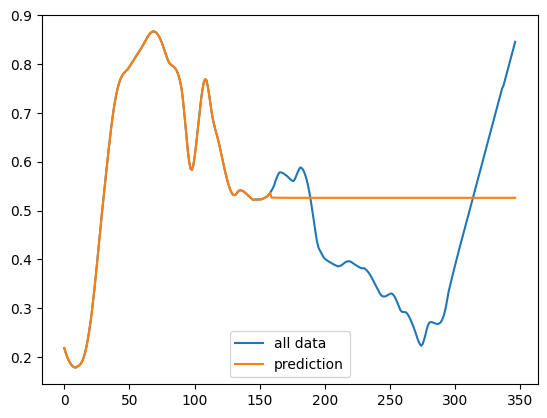

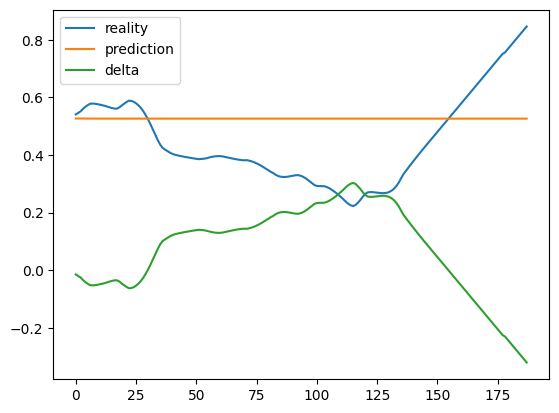

In [20]:
y = data.tolist()
y.extend(output)
delta = output - all_data[-oos:]
# plot all_data
import matplotlib.pyplot as plt
plt.plot(all_data,label='all data')
plt.plot(y,label='prediction')
plt.legend()
plt.show()

# plot d1
plt.plot(all_data[-oos:],label='reality')
plt.plot(output,label='prediction')
plt.plot(delta,label='delta')
plt.legend()
plt.show()